# SARIMA-X where X is Exogenous Regressor 

In [1]:
# usual imports #
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# ignore the unwanted warnings #
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
# consistent plot size #
from pylab import rcParams
rcParams['figure.figsize']=12,5

In [101]:
# import the statsmodels #
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA,ARMA


In [102]:
# import the dataset for the exercise #
rest_full = pd.read_csv('../Data/RestaurantVisitors.csv',index_col='date',parse_dates=True)

In [103]:
rest_full.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65.0,25.0,67.0,139.0,296.0
2016-01-02,Saturday,0,na,24.0,39.0,43.0,85.0,191.0
2016-01-03,Sunday,0,na,24.0,31.0,66.0,81.0,202.0
2016-01-04,Monday,0,na,23.0,18.0,32.0,32.0,105.0
2016-01-05,Tuesday,0,na,2.0,15.0,38.0,43.0,98.0


In [104]:
rest_full.index

DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10',
               ...
               '2017-05-22', '2017-05-23', '2017-05-24', '2017-05-25',
               '2017-05-26', '2017-05-27', '2017-05-28', '2017-05-29',
               '2017-05-30', '2017-05-31'],
              dtype='datetime64[ns]', name='date', length=517, freq=None)

In [105]:
rest_full.index.freq = 'D'

In [106]:
rest_full.tail()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2017-05-27,Saturday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-28,Sunday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-29,Monday,1,Memorial Day,NaN,NaN,NaN,NaN,NaN
2017-05-30,Tuesday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-31,Wednesday,0,na,NaN,NaN,NaN,NaN,NaN


In [107]:
rest = rest_full.copy()

In [108]:
rest.dropna(inplace=True)

In [109]:
# change the datatype of the selected columns #
cols = ['rest1', 'rest2', 'rest3','rest4','total']

for col in cols:
    rest[col] = rest[col].astype(int)

In [110]:
rest.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65,25,67,139,296
2016-01-02,Saturday,0,na,24,39,43,85,191
2016-01-03,Sunday,0,na,24,31,66,81,202
2016-01-04,Monday,0,na,23,18,32,32,105
2016-01-05,Tuesday,0,na,2,15,38,43,98


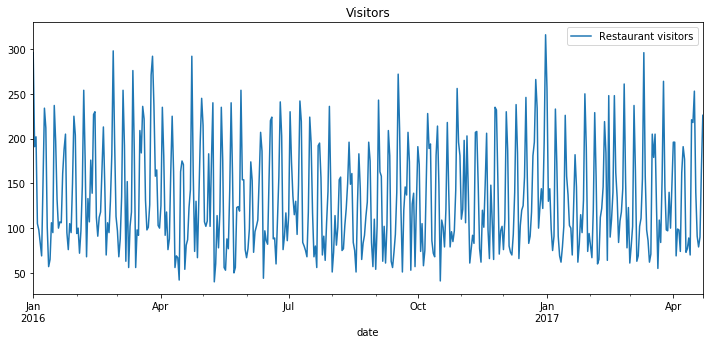

In [111]:
# plot the source data #
rest['total'].plot(legend=True,label='Restaurant visitors',title='Visitors')

## Holidays  
- Exogenous Regressors

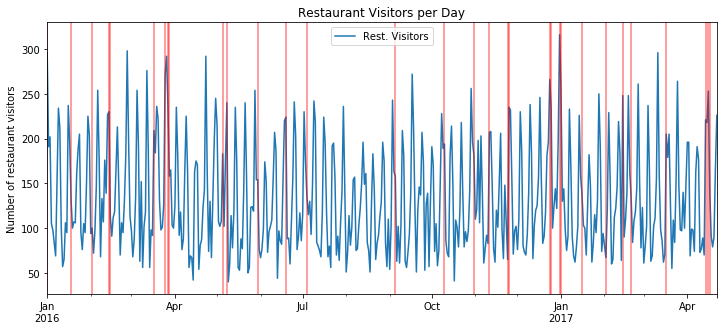

In [112]:
title = 'Restaurant Visitors per Day'
xlabel = ''
ylabel = 'Number of restaurant visitors'

ax = rest['total'].plot(legend=True,label='Rest. Visitors',title=title)
ax.set(ylabel=ylabel,xlabel=xlabel)
ax.autoscale(axis='x',tight=True)

for x in rest.query('holiday==1').index:
    ax.axvline(x=x,color='r',alpha=0.5)

In [113]:
rest[rest['holiday']==1].index # this is same as rest.query('holiday==1').index

DatetimeIndex(['2016-01-01', '2016-01-18', '2016-02-02', '2016-02-14',
               '2016-02-15', '2016-03-17', '2016-03-25', '2016-03-27',
               '2016-03-28', '2016-05-05', '2016-05-08', '2016-05-30',
               '2016-06-19', '2016-07-04', '2016-09-05', '2016-10-10',
               '2016-10-31', '2016-11-11', '2016-11-24', '2016-11-25',
               '2016-12-24', '2016-12-25', '2016-12-31', '2017-01-01',
               '2017-01-16', '2017-02-02', '2017-02-14', '2017-02-20',
               '2017-03-17', '2017-04-14', '2017-04-16', '2017-04-17'],
              dtype='datetime64[ns]', name='date', freq=None)

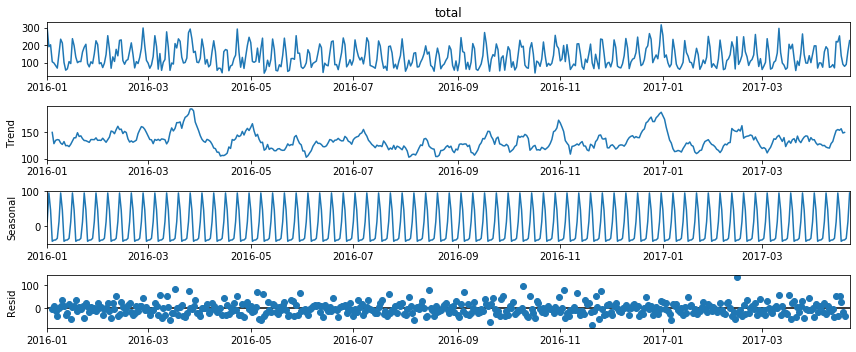

In [114]:
# run an ETS decomposition to separate the trend and seasonality of the data #
seasonal_decompose(rest['total'],model='additive').plot();

### check for stationarity of the data using the Augment Dickey fuller test 


In [115]:
# create a convenience function for dickey fuller test of stationarity #

def dickey_fuller(series,title='Your Dataset'):
    from statsmodels.tsa.stattools import adfuller
    
    print(f'Augmented Dickey Fuller Test of {title}\n')
    result = adfuller(series.dropna(),autolag='AIC')
    
    df = pd.Series(result[0:4],index=['test-statistics','p-Value','# lags used','# observations'])
    
    print (df.to_string())
    
    for key,value in result[4].items():
        print (f'critical {key} value is {value}')
               
                 
    if result[1] < 0.05:
        print ('There is sufficient evidence against the Null Hypothesis')
        print ('We reject the Null Hypothesis')
        print ('Conclusion: The provided dataset is stationary')
    else:
        print ('There is not sufficient evidence against the Null Hypothesis')
        print ('We fail to reject the Null Hypothesis')
        print ('Conclusion: The provided dataset is non-stationary')

In [116]:
dickey_fuller(rest['total'],title='Restuarants Visitors in the US')

Augmented Dickey Fuller Test of Restuarants Visitors in the US

test-statistics     -5.592497
p-Value              0.000001
# lags used         18.000000
# observations     459.000000
critical 1% value is -3.4446773373329576
critical 5% value is -2.8678574606780654
critical 10% value is -2.5701349669405404
There is sufficient evidence against the Null Hypothesis
We reject the Null Hypothesis
Conclusion: The provided dataset is stationary


In [117]:
auto_arima(rest['total'],seasonal=True,m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                         y   No. Observations:                  478
Model:             SARIMAX(1, 0, [1], 7)   Log Likelihood               -2384.908
Date:                   Sun, 12 Jul 2020   AIC                           4777.816
Time:                           09:31:54   BIC                           4794.495
Sample:                                0   HQIC                          4784.373
                                   - 478                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.9779      1.671      2.979      0.003       1.702       8.253
ar.S.L7        0.9602      0.013     74.406      0.000       0.935       0.985
ma.S.L7       -0.7410      0.049    -15.252      0.000      -0.836      -0.646
sigma2      1193.9784     69.427     17.198      0.000    1057.904    1330.053
===================================================================================
Ljung-Box (Q):                       68.47   Jarque-Bera (JB):                62.56
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.74
Prob(H) (two-sided):                  0.33   Kurtosis:                         3.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [118]:
# split the data into train and test set #
train = rest.iloc[:400]
test = rest.iloc[400:]

In [119]:
# train the model using the SARIMA model first - exogenous variable is not added #
model =  SARIMAX(train['total'],seasonal_order=(1, 0, [1], 7),enforce_invertibility=False)

In [120]:
fitt = model.fit()

In [121]:
test_predictions = fitt.predict(start=len(train),end=len(train)+len(test)-1,dynamic=False,
                                typ='levels').rename('SARIMAX (1,0,[1],7)')

In [122]:
fitt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               total   No. Observations:                  400
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 7)   Log Likelihood               -1974.348
Date:                             Sun, 12 Jul 2020   AIC                           3956.697
Time:                                     09:32:07   BIC                           3972.663
Sample:                                 01-01-2016   HQIC                          3963.019
                                      - 02-03-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2513      0.044      5.665      0.000       0.164       0.338
ar.S.L7        0.9999      0.000   8245.009      0.000       1.000       1.000
ma.S.L7       -0.9453      0.024    -39.469      0.000      -0.992      -0.898
sigma2      1044.4953     66.088     15.805      0.000     914.965    1174.025
===================================================================================
Ljung-Box (Q):                       31.39   Jarque-Bera (JB):                36.42
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             0.58
Prob(H) (two-sided):                  0.35   Kurtosis:                         3.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

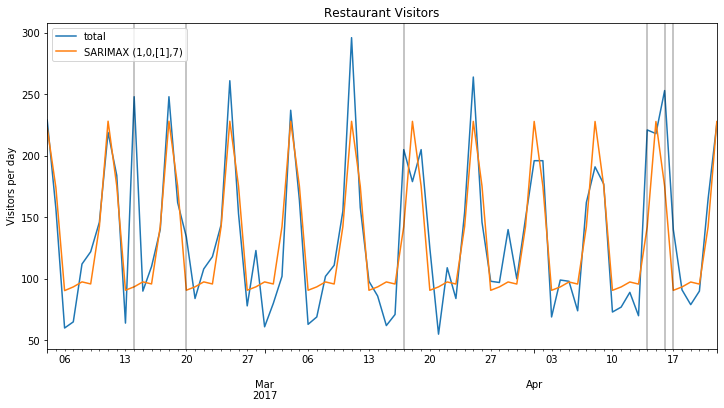

In [123]:
# Plot predictions against known values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = test['total'].plot(legend=True,figsize=(12,6),title=title)
test_predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

In [124]:
# Model Evaluation 

In [125]:
from statsmodels.tools.eval_measures import mse,rmse

RMSE = rmse(test['total'],test_predictions)
MSE =  mse(test['total'],test_predictions)


In [126]:
print (f'RMSE of the model is {RMSE:11.10}')
print (f'MSE of the model is {MSE:11.10}')

RMSE of the model is 32.29486915
MSE of the model is 1042.958573


# Add the Exogenous variable into the model 

In [127]:
model = SARIMAX(endog=train['total'],exog=train['holiday'],seasonal_order=(1,0,[1],7),enforce_invertibility=False)
fitt = model.fit()
fitt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               total   No. Observations:                  400
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 7)   Log Likelihood               -1919.453
Date:                             Sun, 12 Jul 2020   AIC                           3848.907
Time:                                     09:32:15   BIC                           3868.864
Sample:                                 01-01-2016   HQIC                          3856.810
                                      - 02-03-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday       65.2402      4.468     14.601      0.000      56.482      73.998
ar.L1          0.2264      0.045      5.056      0.000       0.139       0.314
ar.S.L7        1.0000   5.81e-05   1.72e+04      0.000       1.000       1.000
ma.S.L7       -0.9593      0.023    -41.002      0.000      -1.005      -0.913
sigma2       783.6126     50.788     15.429      0.000     684.071     883.154
===================================================================================
Ljung-Box (Q):                       38.24   Jarque-Bera (JB):                12.52
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               0.95   Skew:                             0.18
Prob(H) (two-sided):                  0.77   Kurtosis:                         3.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [128]:
test_predictions = fitt.predict(start=len(train),end=len(train)+len(test)-1,exog=test[['holiday']]).rename('SARIMAX (1,0,0) (1,0,0,7) Predictions')

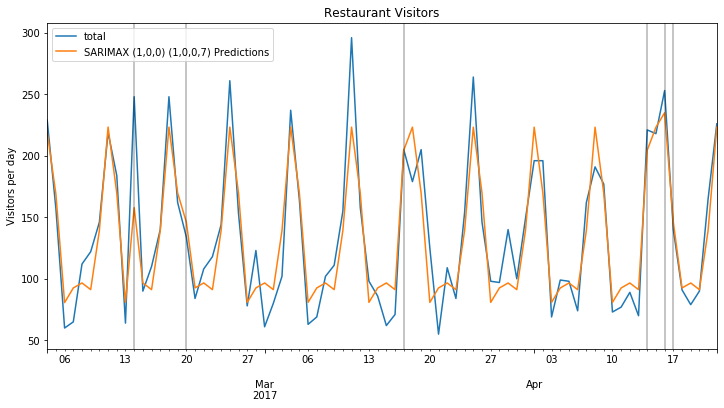

In [129]:
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = test['total'].plot(legend=True,figsize=(12,6),title=title)
test_predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

In [130]:
# evaluate the models #

In [131]:
print(f'SARIMA(1,0,0)(2,0,0,7) MSE Error: {MSE:11.10}')
print(f'SARIMA(1,0,0)(2,0,0,7) RMSE Error: {RMSE:11.10}')
print()

MSEx = mse(test['total'], test_predictions)
RMSEx = rmse(test['total'], test_predictions)

# Print new SARIMAX values
print(f'SARIMAX(1,0,0)(2,0,0,7) MSE Error: {MSEx:11.10}')
print(f'SARIMAX(1,0,0)(2,0,0,7) RMSE Error: {RMSEx:11.10}')

SARIMA(1,0,0)(2,0,0,7) MSE Error: 1042.958573
SARIMA(1,0,0)(2,0,0,7) RMSE Error: 32.29486915

SARIMAX(1,0,0)(2,0,0,7) MSE Error: 584.0521794
SARIMAX(1,0,0)(2,0,0,7) RMSE Error: 24.16717152


### Retrain the model on the entire dataset and forecast into the real future

In [132]:
model = SARIMAX(endog=rest['total'],exog=rest['holiday'],order=(1,0,0),
               seasonal_order=(1,0,1,7))

In [133]:
fitt = model.fit()

In [134]:
predictions = fitt.predict(start=len(rest),end=len(rest)+38,exog=rest_full[478:][['holiday']],dynamic=False,typ='levels')

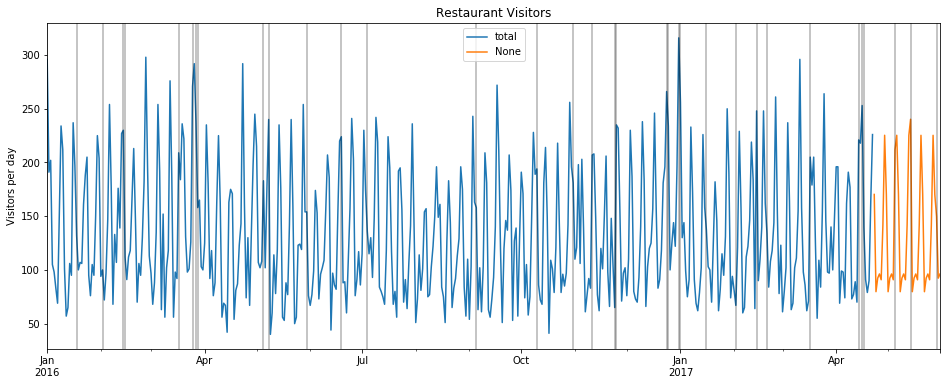

In [137]:
# Plot the forecast alongside historical values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = rest['total'].plot(legend=True,figsize=(16,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in rest_full.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

# Thank You